In [57]:
import os
import numpy as np 
from numpy import cos, sin
import matplotlib.pyplot as plt
import multiprocessing
import time
# import visualisation
from rect_metric import compare_grasps, grasp_accuracy

%matplotlib inline

import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torch.optim as optim
torch.backends.cudnn.benchmark = True 

import torchvision as tv


print("Using torch", torch.__version__)

Using torch 1.11.0


In [58]:
# Fetching the device that will be used throughout this notebook

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_PATH = "drive/MyDrive/Liverpool/Assignments/Year 3/COMP341/COMP341 - Assignment 01 - Data/Data/"
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    !pip install shapely
except:
    print('not in drive')
    DATASET_PATH = 'ass1_data/Data'
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:1")
print("Using device", device)



not in drive
Using device cuda:1


In [59]:
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_epochs(train_history, val_history, plotType="loss"):
    x = np.arange(1, len(train_history) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x, val_history, color=colors[1], label=f"Validation {plotType}", linewidth=2)
    plt.plot(x, train_history, color=colors[0], label=f"Training {plotType}", linewidth=2)
    plt.ylabel(f'{plotType}')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title(f"Evolution of the training and validation {plotType}")
    plt.show()

In [60]:
def get_cnn_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [61]:
import shapely.geometry
import shapely.affinity

class RotatedRect:
    def __init__(self, centerx, centery, angle, width, height):
        self.centerx = centerx
        self.centery = centery
        self.angle = angle
        self.width = width
        self.height = height

    def get_contour(self):
        width = self.width
        height = self.height
        contour = shapely.geometry.box(-width/2.0, -height/2.0, width/2.0, height/2.0)
        rotContour = shapely.affinity.rotate(contour, self.angle)
        return shapely.affinity.translate(rotContour, self.centerx, self.centery)

    def intersection(self, other):
        return self.get_contour().intersection(other.get_contour())

def compare_grasps(rect1, rect2):
    r1 = RotatedRect(*rect1)
    r2 = RotatedRect(*rect2)
    
    intersection = r1.intersection(r2).area
    union = (r1.width*r1.height) + (r2.width*r2.height) - intersection
    score = intersection/union
    return score



In [62]:
def grasp_accuracy(Ys, Y_hats):
    scores = [compare_grasps(Ys[i], Y_hats[i]) for i, g in enumerate(Ys)]
    print(scores)
    avg = lambda x: sum(x)/len(x)
    return avg(scores)

In [63]:
from torch.utils.data import Dataset
from PIL import Image

class GraspDataset(Dataset):

  def __init__(self, root_dir, depth_image=None):
      self.root_dir = root_dir
      self.depth_image = depth_image

      # List of all scenes for all objects in the dataset
      self.scene_paths = []
      for object_name in os.listdir(root_dir):
        for scene_index in range(5): # Scene index ranges from 0 to 4 for all objects

          scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"

          # Make sure a scene with this index exists for this object
          grasp_path = scene_root + "grasps.txt"
          if not os.path.exists(grasp_path): continue

          # Add scene files and appened to the list
          scene = {
              "grasps": grasp_path,
              "rgb": scene_root + "RGB.png",
              "mask": scene_root + "mask.png",
              "pDepth": scene_root + "perfect_depth.tiff",
              "sDepth": scene_root + "stereo_depth.tiff"
          }
          self.scene_paths.append(scene)

  # This must return the length of the dataset
  def __len__(self):
    return len(self.scene_paths)

  # This must return the single dataset item at index idx
  def __getitem__(self, idx):

    # Load the grasps
    grasps = []
    with open(self.scene_paths[idx]["grasps"]) as file:
      lines = file.readlines()
      for line in lines:
        x, y, theta, openning, jaw_size = [float(number) for number in line.split(";")]
        grasp = [x, y, theta, openning, jaw_size]
        grasps.append(grasp)
    grasps = np.array(grasps, dtype=np.float32)

    # Load the RGB image
    image = Image.open(self.scene_paths[idx]["rgb"])
    rgb = np.array(image, dtype=np.float32) / 255

    # # Reshape the image from HxWx3 to 3xHxW
    rgb_reshaped = np.zeros([3, rgb.shape[0], rgb.shape[1]])
    rgb_reshaped[0,:,:] = rgb[:,:,0]
    rgb_reshaped[1,:,:] = rgb[:,:,1]
    rgb_reshaped[2,:,:] = rgb[:,:,2]
    
    # Convert from [0, 1] to [-1, 1]
    rgb_norm = np.zeros([3, rgb.shape[0], rgb.shape[1]])
    rgb_norm[0, :, :] = (rgb_reshaped[0,:,:] - 0.5) / 0.5
    rgb_norm[1, :, :] = (rgb_reshaped[1,:,:] - 0.5) / 0.5
    rgb_norm[2, :, :] = (rgb_reshaped[2,:,:] - 0.5) / 0.5

    if self.depth_image is not None:

      if self.depth_image == "perfect":
        depth = Image.open(self.scene_paths[idx]["pDepth"])
      elif self.depth_image == "stereo":
        depth = Image.open(self.scene_paths[idx]["sDepth"])

      depth = np.array(depth, dtype=np.float32)
      return (rgb_norm, depth, grasps[0])

    return (rgb_norm, grasps[0])

grasp: tensor([512.5854, 494.2139, -64.5562, 163.5000,  25.6021])
depth: tensor([512.5854, 494.2139, -64.5562, 163.5000,  25.6021])


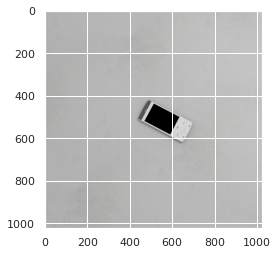

In [64]:
# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    npimg = np.transpose(npimg, (1, 2, 0))
    
    plt.imshow(npimg)
# Show off the dataset
index = 3
dataset = GraspDataset(DATASET_PATH + "/training")
loader = td.DataLoader(dataset, batch_size=4, shuffle=False, drop_last=False, num_workers=2)

batch = next(iter(loader))
image_array = np.uint8(np.array(batch[0][index]) * 255)

print("grasp:", batch[1][index])
print("depth:", batch[1][index])
imshow(batch[0][index])

In [65]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)


num_workers = multiprocessing.cpu_count()

def gen_transforms(resize=None, imgs_mean=(0.5,), imgs_std=(0.5,)):
    tst_trans = [tv.transforms.ToTensor()]
    if resize is not None:
        tst_trans.append(tv.transforms.Resize(resize[0]))
        tst_trans.append(tv.transforms.CenterCrop(resize[1]))
    tst_trans.append(tv.transforms.Normalize(mean=imgs_mean, std=imgs_std))
    return tv.transforms.Compose(tst_trans)

def get_train_test_data(image_resize=None):
    # transforms = gen_transforms(image_resize)
    trainData = GraspDataset(
        root_dir=f'{DATASET_PATH}/training')
    # a = ({
    #     loader: Callable[[str], Any],
    #     target_transform: Optional[Callable] = None,
    #     is_valid_file: Optional[Callable[[str], bool]] = None,
    # })
    return trainData


def get_train_loader(batchSize, resize=None):
    trainData = get_train_test_data(resize)
    trainLoader = td.DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=False, num_workers=4)
    return trainLoader

trainLoader = get_train_loader(4)

In [66]:
def getLoss():
    return nn.MSELoss()

def getOptimiser(model, learningRate):
    #optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimiser = optim.Adam(model.parameters(), lr=learningRate)
    return optimiser

In [67]:

def train(model, batch_size, n_epochs, learning_rate, resize=None):
    print(f"batch size: {batch_size}")
    print(f"n epochs: {n_epochs}")
    print(f"learning rate: {learning_rate}")
    print("="*20)
    
    trainLoader = get_train_loader(batch_size, resize)
    lossFn = getLoss()
    optimizer = getOptimiser(model, learning_rate)

    train_history = []
    accuracy_history = []
    training_start_time = time.time()
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss = 0
        epoch_accuracy = 0
        
        with tqdm(trainLoader, unit="batch") as tepoch:
            for rgb, grasp in tepoch:   #for each batch
                tepoch.set_description(f"Epoch {epoch}")
                # Move tensors to gpu
                rgb = torch.FloatTensor(rgb.numpy())
                rgb, grasp = rgb.to(device), grasp.to(device)
               
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(rgb)
                # _, predicted = outputs.argmax(dim=1, keepdim=True).squeeze()
                #  = torch.max(outputs, 1)
                # print('out', outputs.size(), 'targets', grasps.size())
                # g = torch.FloatTensor(grasp.cpu().numpy()).to(device)
                loss = lossFn(outputs,  grasp)
                loss.backward()
                optimizer.step()
                # add to running totals
                epoch_loss += loss.item()
                with torch.no_grad():
                    accs = grasp_accuracy(outputs.cpu().numpy(), grasp.cpu().numpy())
                    epoch_accuracy += accs
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy/len(trainLoader))
        
    print(f"Training Finished, took {round(time.time() - training_start_time,1)}s")
    return train_history, accuracy_history

In [68]:
get_cnn_output_size(254, kernel_size=3, stride=2, padding=0)

not int 125.5


126

In [69]:
class DeepConvNN(nn.Module):
    def __init__(self):
        super(DeepConvNN, self).__init__()
        #in = 1047 x 1047
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0), #out = 523x523
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 521x521
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 519x519
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 259x259                 
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), #out = 259x259
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0), #out = 129x129
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #out = 129x129
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            # MaxPool could be used instead of stride 2
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), #out = 127x127
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0), #out = 63x63
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),  #out = 61x61
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0), #out = 59x59
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0), #out = 29x29
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # nn.Dropout(0.3),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), #out = 14x14
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 256 * 7 * 7 #36864

        self.regressionBlock = nn.Sequential(
            # nn.Dropout(0.5),
            nn.Linear(self.flattened_size, 512),
            nn.Linear(512, 5),
            # nn.Dropout(0.5), 
            # nn.Linear(2048, 5)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        x = self.classificationBlock(x)
        return x

In [70]:
BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 0.001

# resize = (224, 224)
# nnet = VGG11()
resize = (1047, 1047)
nnet = DeepConvNN()

train_loss, train_accuracy = train(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE, resize)

batch size: 4
n epochs: 5
learning rate: 0.001


  0%|          | 0/8 [00:00<?, ?batch/s]

RuntimeError: shape '[-1, 12544]' is invalid for input of size 36864

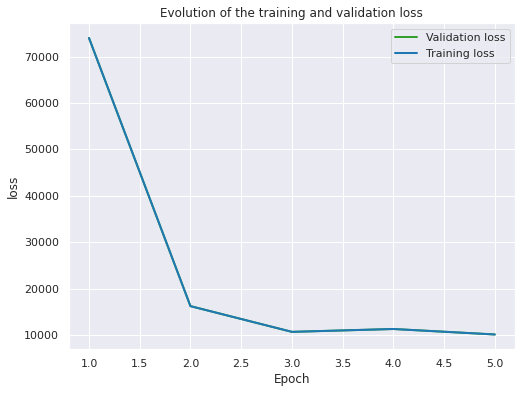

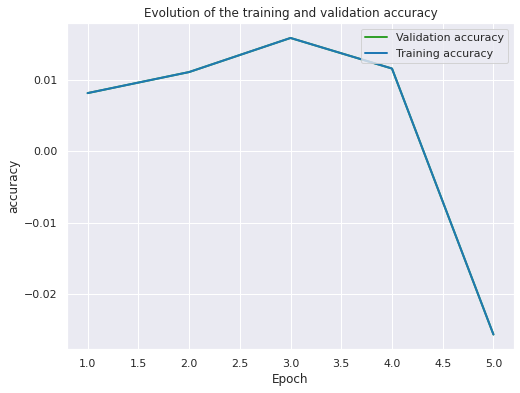

In [ ]:
plot_epochs(train_loss, train_loss, plotType='loss')

plot_epochs(train_accuracy, train_accuracy, plotType='accuracy')
